In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score,recall_score,balanced_accuracy_score, precision_score,f1_score

In [2]:
df = pd.read_csv('../data/cleaning_data_phase2.csv.zip')

### Creating X and y variables

In [3]:
X= df.drop(columns = ['_michd','_state'])
y = df['_michd']

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42)

### Imputing Null Values and One Hot Encoding 

In [5]:
categorical = X.select_dtypes('object').columns
numerical = X.columns.drop(categorical)

In [6]:
ohe = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse=False) 
si_numerical = SimpleImputer(strategy='median')  

In [7]:
ctx = ColumnTransformer(
transformers = [
    ('ohe',ohe,categorical),
    ('si_num',si_numerical,numerical)
])

In [8]:
X_train_ohe_imputed = ctx.fit_transform(X_train)
X_test_ohe_imputed = ctx.transform(X_test)

/Users/markbiernacki/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Random Forest on Imbalanced Data

In [9]:
rf = RandomForestClassifier()

In [10]:
param_dist = {
    'n_estimators': [100],
    'max_depth': [5],
}

rs = RandomizedSearchCV(estimator = rf, param_distributions = param_dist, cv = 3, scoring = 'balanced_accuracy', n_iter =1)


Using Randomized Search CV as opposed to Gridsearch CV in order to maximize efficiency. 
Using balanced_accuracy as the scoring metric, as this is what we want to optimize (instead of training accuracy). For now I am setting the parameters of max depth to be 5, and n_estimators to be 100. I will experiment with different parameters after checking the model performance on various methods of handling the imbalanced data.

In [59]:
rs.fit(X_train_ohe_imputed,y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=1,
                   param_distributions={'max_depth': [5],
                                        'n_estimators': [100]},
                   scoring='balanced_accuracy')

### Creating Evaluation Function

In [60]:
def evaluation(X_test, y_test, preds, model):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    
    b_acc = balanced_accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds, pos_label= 'Yes')
    prec = precision_score(y_test, preds, pos_label= 'Yes')
    f1 = f1_score(y_test, preds, pos_label= 'Yes')

    print(f'balanced_accuracy: {b_acc}')
    print(f'recall: {recall}')
    print(f'precision: {prec}')
    print(f'f1 score: {f1}')

    return {
        'balanced_accuracy': b_acc,
        'recall': recall,
        'precision': prec,
        'f1_score': f1
    }

In [61]:
preds1 = rs.predict(X_test_ohe_imputed)

balanced_accuracy: 0.5005257814706086
recall: 0.001062072220911022
precision: 0.9
f1 score: 0.0021216407355021216


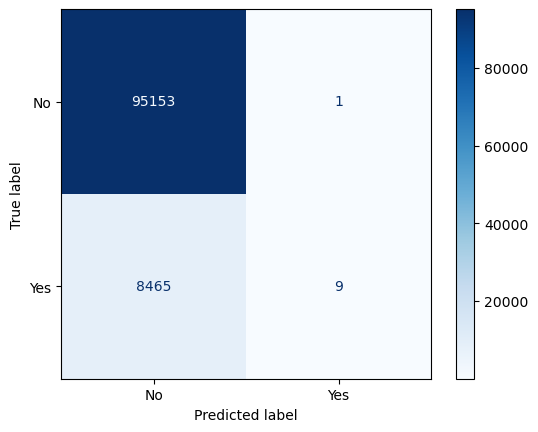

In [62]:
scores = []
scores.append(evaluation(X_test_ohe_imputed,y_test,preds1,rs))

This model performs very poorly. It only predicted 'yes' 13 times total as it heavily favors the majority class.

### Oversample the minority class


In [11]:
pipe_oversample = ImbPipeline(steps = [
    ('sampling',RandomOverSampler(random_state = 42)),
    ('model',rs)
])

In [ ]:
pipe_oversample.fit(X_train_ohe_imputed,y_train)

In [ ]:
preds_oversample = pipe_oversample.predict(X_test_ohe_imputed)

balanced_accuracy: 0.7720198256160025
recall: 0.8260561718196837
precision: 0.20688636027781881
f1 score: 0.3308988631260488


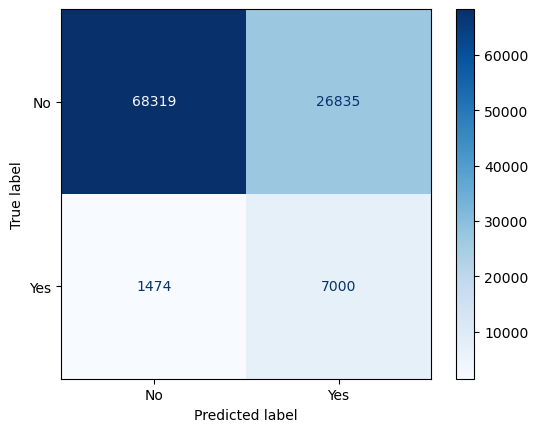

In [66]:
scores.append(evaluation(X_test_ohe_imputed,y_test,preds_oversample,pipe_oversample))

Oversampling the minority class led to significantly higher recall and balanced_accuracy

### SMOTE

In [67]:
pipe_smote = ImbPipeline(steps = [
    ('sampling',SMOTE(random_state = 42)),
    ('model',rs)
])

balanced_accuracy: 0.7017529250336544
recall: 0.517111163559122
precision: 0.2884412848867825
f1 score: 0.37032029071241446


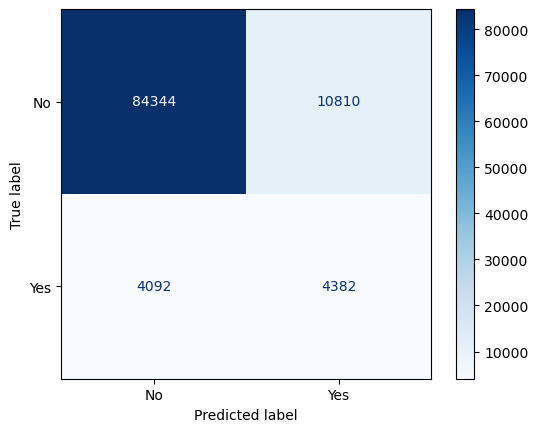

In [68]:
pipe_smote.fit(X_train_ohe_imputed,y_train)
preds_smote = pipe_smote.predict(X_test_ohe_imputed)
scores.append(evaluation(X_test_ohe_imputed,y_test,preds_smote,pipe_smote))

Using Smote to account for the imbalanced data produced worse results than oversampling the minority class

### ADASYN

In [69]:
pipe_adasyn = ImbPipeline(steps = [
    ('sampling',ADASYN(random_state = 42)),
    ('model',rs)
])

balanced_accuracy: 0.7055674847579108
recall: 0.5258437573755015
precision: 0.289896558454232
f1 score: 0.373747116795974


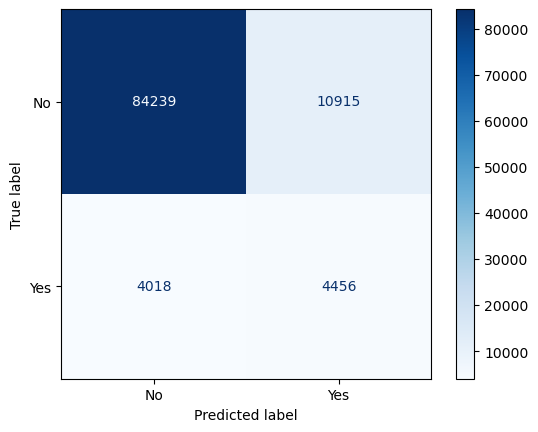

In [70]:
pipe_adasyn.fit(X_train_ohe_imputed,y_train)
preds_adasyn = pipe_adasyn.predict(X_test_ohe_imputed)
scores.append(evaluation(X_test_ohe_imputed,y_test,preds_adasyn,pipe_adasyn))

Using ADASYN yielded worse results than oversampling the minority class.

### Oversample Method with hypertuned parameters
Since this method produced the highest balanced accuracy and recall, we can now try to optimize the model based on several parameters.

In [71]:
param_dist = {
    'sampling__sampling_strategy':[.25,.75],
    'model__n_estimators': [100,200,300],
    'model__max_depth': [5,10,15,20],
}
pipe_oversample_gridsearch= ImbPipeline(steps = [
    ('sampling',RandomOverSampler(random_state = 42)),
    ('model',rf)
])


In [72]:
rs2 = RandomizedSearchCV(estimator = pipe_oversample_gridsearch, param_distributions = param_dist, cv = 3, scoring = 'balanced_accuracy',n_jobs = -1)

In [73]:
rs2.fit(X_train_ohe_imputed,y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('sampling',
                                              RandomOverSampler(random_state=42)),
                                             ('model',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'model__max_depth': [5, 10, 15, 20],
                                        'model__n_estimators': [100, 200, 300],
                                        'sampling__sampling_strategy': [0.25,
                                                                        0.75]},
                   scoring='balanced_accuracy')

In [74]:
oversample_gridsearch_preds= rs2.predict(X_test_ohe_imputed)

balanced_accuracy: 0.7765848525815442
recall: 0.7671701675713949
precision: 0.2419967242406194
f1 score: 0.36793253721206637


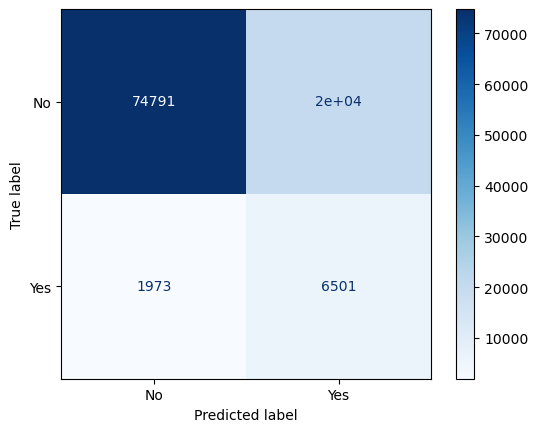

In [75]:
scores.append(evaluation(X_test_ohe_imputed,y_test,oversample_gridsearch_preds,rs2))

This model slightly improved the balanced_accuracy but drastically reduced the recall. 
The Oversampling without hypertuned parameters performed the best on the average of recall and balanced accuracy. 

In [76]:
scores

[{'balanced_accuracy': 0.5005257814706086,
  'recall': 0.001062072220911022,
  'precision': 0.9,
  'f1_score': 0.0021216407355021216},
 {'balanced_accuracy': 0.7720198256160025,
  'recall': 0.8260561718196837,
  'precision': 0.20688636027781881,
  'f1_score': 0.3308988631260488},
 {'balanced_accuracy': 0.7017529250336544,
  'recall': 0.517111163559122,
  'precision': 0.2884412848867825,
  'f1_score': 0.37032029071241446},
 {'balanced_accuracy': 0.7055674847579108,
  'recall': 0.5258437573755015,
  'precision': 0.289896558454232,
  'f1_score': 0.373747116795974},
 {'balanced_accuracy': 0.7765848525815442,
  'recall': 0.7671701675713949,
  'precision': 0.2419967242406194,
  'f1_score': 0.36793253721206637}]

In [79]:
evaluations = pd.DataFrame(scores, index = ['imbalanced data','oversampling','SMOTE','ADASYN','Hypertuned Oversampling'])

In [82]:
evaluations.to_csv('../data/scores_RandomForest.csv')

### Inference
Producing Probabilities that an individual has heart disease using the best model (RF with oversampling). This is an example imlementation that could be used by healthcare professionals.

In [ ]:
test_proba = pipe_oversample.predict_proba(X_test_ohe_imputed)

In [ ]:
test_proba

Getting the most important features from the random forest model

In [ ]:
rf_model = pipe_oversample.named_steps['model'].best_estimator_

feature_importances = rf_model.feature_importances_

In [ ]:
feature_importances.shape

In [ ]:
importance_dict = dict(zip(ctx.get_feature_names_out(), feature_importances))


In [ ]:
sorted_importance_dict = dict(sorted(importance_dict.items(), key = lambda item: item[1], reverse = True))

In [ ]:
top5_list = list(sorted_importance_dict.items())[:5]

In [ ]:
top5_df = pd.DataFrame(top5_list,columns = ['Feature','Importance'])

In [ ]:
plt.figure()
plt.barh(top5_df['Feature'],top5_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 5 Feature Importances')
plt.tight_layout()
plt.savefig('../graph/top_5_feature_importances.png')

This graph shows the five most important features according to the random forest model with oversampling. We can see that taking cholestoral medicine (or not), having been told that you have high blood pressure (or not) and age are the most important features in the model.